In [6]:
import glob
import pandas as pd

for file in glob.glob('data/**/*.pkl'):
    df = pd.read_pickle(file)
    df['index_col'] = df.index
    df.reset_index().to_feather(file.replace('.pkl', '.feather'))

for file in glob.glob('data/**/*.pkl'):
    df = pd.read_pickle(file)
    df['index_col'] = df.index
    df.reset_index().to_feather(file.replace('.pkl', '.feather'))


In [1]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [20]:
def gather_df(dataset_name):
    fname = "./data/kaggle-preprocessed/{}.pkl".format(dataset_name)
    if not os.path.exists(fname):
        raise Exception("preprocessed file doesnt exist")
    df = pd.read_pickle(fname)

    related_datas = []
    for col in df.columns:
        if "rain" in col:
            location = col.replace("rainfall_", "")
        elif "temperature" in col:
            location = col.replace("temperature_", "")
        else:
            continue
        filename = "./data/nasa-power/{}.pkl".format(location)
        if os.path.exists(filename):
            df_related = pd.read_pickle(filename)
            df_related.columns = [
                "{}_{}".format(location, c.lower()) for c in df_related.columns
            ]
            related_datas.append(df_related)
        else:
            print("not found: {}".format(col))
    df_related = pd.concat(related_datas)
    df_related = df_related.groupby(df_related.index).max()
    df = pd.merge(df, df_related, how="left", left_index=True, right_index=True)

    #     for col in df.columns:
    #         if "target_" in col:
    #             df["{}_10_mean".format(col)] = df[col].rolling(10).mean()
    #             df["{}_10_std".format(col)] = df[col].rolling(10).std()
    #             df["{}_1y_ago".format(col)] = df[col].shift(365)
    #             df["{}_1y_ago_10_mean".format(col)] = df[col].rolling(10).mean().shift(365)

    #     #     for col in ["year", "month", "week", "day_of_year"]:
    #     #         df = df.drop(col, 1)
    #     for col in tqdm.tqdm(df.columns):
    #         decomp = seasonal_decompose(
    #             df[col].ffill().fillna(0),
    #             freq=52,
    #             model="additive",
    #             extrapolate_trend="freq",
    #         )
    #         df[f"{col}_trend"] = decomp.trend
    #         df[f"{col}_resid"] = decomp.resid
    #         df[f"{col}_seasonal"] = decomp.seasonal

    return df

In [55]:
df = gather_df("aquifer_luco")
target_col = [c for c in df.columns if "target" in c][0]
y = df[target_col].shift(-90)

# decompose the target signal into trend/season/resid as well
stl = STL(y.ffill().fillna(0), seasonal=13)
res = stl.fit()
dfy = pd.DataFrame(
    {"season": res.seasonal, "trend": res.trend, "resid": res.resid, "y": y}
)
dfy["y_comp"] = dfy.season + dfy.trend + dfy.resid

In [56]:
for col in df.columns:
    if "shift" not in col:
        for i in range(1, 20):
            df["{}_shift_{}".format(col, i)] = df[col].shift(i)

In [58]:
df.dtypes

rainfall_simignano                          float64
rainfall_siena_poggio_al_vento              float64
rainfall_mensano                            float64
rainfall_montalcinello                      float64
rainfall_monticiano_la_pineta               float64
                                             ...   
monteroni_arbia_biena_ws50m_min_shift_15    float64
monteroni_arbia_biena_ws50m_min_shift_16    float64
monteroni_arbia_biena_ws50m_min_shift_17    float64
monteroni_arbia_biena_ws50m_min_shift_18    float64
monteroni_arbia_biena_ws50m_min_shift_19    float64
Length: 3720, dtype: object

In [59]:
# pca might not be a good choice since almost all variables are non-gaussian; the base assumption of PCA
# https://www.sciencedirect.com/science/article/pii/S156625351930377X#sec0025

import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# pca = PCA()
# X_pca = pca.fit_transform(df.fillna(0))

split = 6000

target = dfy.y
X_used = df.values
filtered = ~pd.isna(target)

model = lgb.LGBMRegressor()
model.fit(X_used[filtered][:split], target[filtered][:split])

dfp = pd.DataFrame({"p": model.predict(X_used[split:]), "y": target[split:]})
print(np.mean((dfp.p - dfp.y) ** 2), dfp.corr())

0.0002921617862047372           p         y
p  1.000000  0.998698
y  0.998698  1.000000


In [25]:
df_imp = pd.DataFrame(
    {"importance": model.feature_importances_, "f_name": df.columns}
).sort_values("importance")

df_imp = df_imp[df_imp.importance > 0]
df_imp.iloc[-15:]

,importance,f_name
27,26,simignano_ps
290,27,temperature_mensano_shift_6
338,27,volume_pozzo_4_shift_9
25,31,day_of_year
14,32,temperature_siena_poggio_al_vento
396,32,simignano_ps_shift_4
34,34,simignano_t2m_min
278,34,temperature_siena_poggio_al_vento_shift_3
397,35,simignano_ps_shift_5
12,37,target_depth_to_groundwater_pozzo_3


In [27]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_used[filtered][:split])

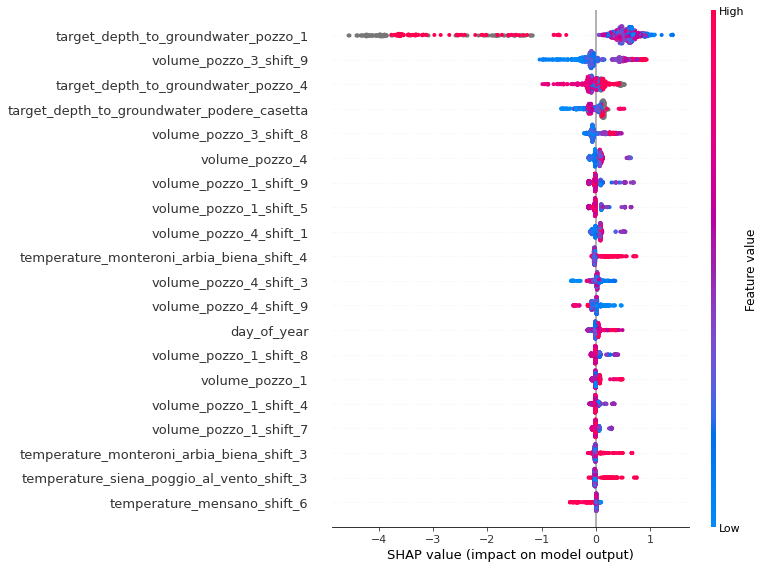

In [31]:
shap.summary_plot(shap_values, df[filtered].iloc[:split])

In [184]:
for alpha in [0.1, 0.5, 0.9]:
    model = lgb.LGBMRegressor(objective="quantile", alpha=alpha)
    model.fit(X_used[filtered][:split], target[filtered][:split])
    dfp["p_{}".format(alpha)] = model.predict(X_used[split:])

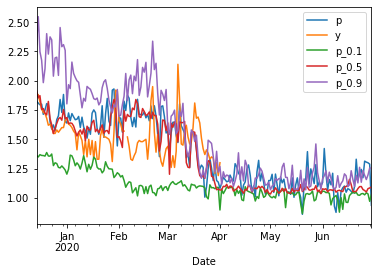

In [150]:
dfp.iloc[-200:].plot()

In [151]:
(dfp.y <= dfp["p_0.9"]).astype(int).mean()

0.48847926267281105

In [60]:
ps = []
for c in ["season", "resid", "trend"]:
    model = lgb.LGBMRegressor()
    model.fit(X_used[filtered][:split], dfy[c].values[filtered][:split])
    ps.append(model.predict(X_used[split:]))
# dfp = pd.DataFrame({"p": np.sum(np.array(ps).T, axis=1), "y": target[split:]})
# print(np.mean((dfp.p - dfp.y) ** 2), dfp.corr())

In [61]:
dfp = dfy[filtered][split:].copy()
dfp["p_season"] = ps[0]
dfp["p_resid"] = ps[1]
dfp["p_trend"] = ps[2]

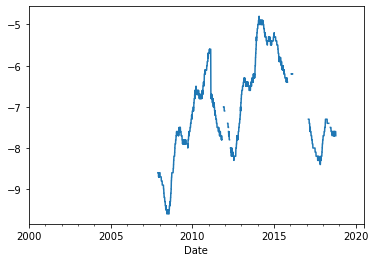

In [67]:
dfy.y.plot()

In [62]:
dfp["p_total"] = dfp.p_season + dfp.p_resid + dfp.p_trend

print(np.mean((dfp.p_total - dfp.y) ** 2), dfp.corr())

nan           season  trend  resid   y  y_comp  p_season   p_resid   p_trend  \
season       NaN    NaN    NaN NaN     NaN       NaN       NaN       NaN   
trend        NaN    NaN    NaN NaN     NaN       NaN       NaN       NaN   
resid        NaN    NaN    NaN NaN     NaN       NaN       NaN       NaN   
y            NaN    NaN    NaN NaN     NaN       NaN       NaN       NaN   
y_comp       NaN    NaN    NaN NaN     NaN       NaN       NaN       NaN   
p_season     NaN    NaN    NaN NaN     NaN  1.000000  0.067110 -0.104895   
p_resid      NaN    NaN    NaN NaN     NaN  0.067110  1.000000 -0.167897   
p_trend      NaN    NaN    NaN NaN     NaN -0.104895 -0.167897  1.000000   
p_total      NaN    NaN    NaN NaN     NaN -0.068626 -0.110527  0.997770   

           p_total  
season         NaN  
trend          NaN  
resid          NaN  
y              NaN  
y_comp         NaN  
p_season -0.068626  
p_resid  -0.110527  
p_trend   0.997770  
p_total   1.000000  


In [44]:
dfp

,season,trend,resid,y,y_comp,p_season,p_resid,p_trend
Date,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,0.028623,0.079603,-13.015973
1,NaN,NaN,NaN,NaN,NaN,0.019181,0.155938,-13.085297
2,NaN,NaN,NaN,NaN,NaN,0.044896,0.138354,-13.125997
3,NaN,NaN,NaN,NaN,NaN,0.010691,0.102689,-13.134095
4,NaN,NaN,NaN,NaN,NaN,-0.002338,0.081648,-13.246326
...,...,...,...,...,...,...,...,...
1482,NaN,NaN,NaN,NaN,NaN,-0.222169,0.028855,-11.041973
1483,NaN,NaN,NaN,NaN,NaN,-0.168708,0.045622,-11.072733
1484,NaN,NaN,NaN,NaN,NaN,-0.281341,-0.031858,-10.930196
